In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20,3)

In [3]:
df = pd.read_csv("./datasetku/data-inflasi2.csv")
df.head()

,Periode,Data Inflasi
0,Juli 2024,2.13 %
1,Juni 2024,2.51 %
2,Mei 2024,2.84 %
3,April 2024,3 %
4,Maret 2024,3.05 %


In [4]:
#Rename Bulan
month_name = {
    'Januari': 'January', 'Februari': 'February', 'Maret': 'March', 'April': 'April',
    'Mei': 'May', 'Juni': 'June', 'Juli': 'July', 'Agustus': 'August', 'September': 'September',
    'Oktober': 'October', 'November': 'November', 'Desember': 'December'
}

df['Periode'] = df['Periode'].replace(month_name, regex=True)
df['Periode'] = pd.to_datetime(df['Periode'], format='%B %Y') + pd.offsets.MonthEnd(1)
df.set_index('Periode', inplace=True)

df['Inflasi'] = df['Data Inflasi'].str.replace(' %', '').astype('float32')
df.drop(columns='Data Inflasi', inplace=True)

df

,Inflasi
Periode,
2024-07-31,2.13
2024-06-30,2.51
2024-05-31,2.84
2024-04-30,3.00
2024-03-31,3.05
...,...
2003-05-31,7.15
2003-04-30,7.62
2003-03-31,7.17


In [5]:
df = df.sort_index()

In [6]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2003-01-31 to 2024-07-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Inflasi  259 non-null    float32
dtypes: float32(1)
memory usage: 3.0 KB
None
          Inflasi
count  259.000000
mean     5.530425
std      3.292659
min      1.320000
25%      3.240000
50%      4.690000
75%      6.860000
max     18.379999


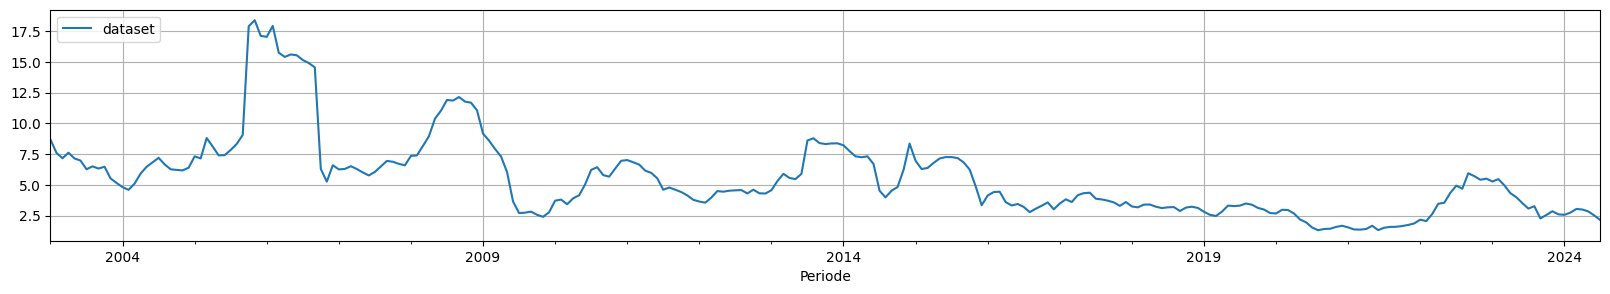

In [7]:
df.plot()
plt.legend(["dataset"], loc="upper left")
plt.show()

In [8]:
from itertools import islice

import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.dataset.split import split

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [9]:
dataset = PandasDataset(df, target="Inflasi")
# dataset = ListDataset(
#     [{'start':df.index[0], 'target':df['Inflasi'].values}],
#     freq='M'
# )
print(dataset)

PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>


In [10]:
#Checking dataset
entry = next(iter(dataset))
print(entry)

{'start': Period('2003-01', 'M'), 'target': array([ 8.68,  7.6 ,  7.17,  7.62,  7.15,  6.98,  6.27,  6.51,  6.33,
        6.48,  5.53,  5.16,  4.82,  4.6 ,  5.11,  5.92,  6.47,  6.83,
        7.2 ,  6.67,  6.27,  6.22,  6.18,  6.4 ,  7.32,  7.15,  8.81,
        8.12,  7.4 ,  7.42,  7.84,  8.33,  9.06, 17.89, 18.38, 17.11,
       17.03, 17.92, 15.74, 15.4 , 15.6 , 15.53, 15.15, 14.9 , 14.55,
        6.29,  5.27,  6.6 ,  6.26,  6.3 ,  6.52,  6.29,  6.01,  5.77,
        6.06,  6.51,  6.95,  6.88,  6.71,  6.59,  7.36,  7.4 ,  8.17,
        8.96, 10.38, 11.03, 11.9 , 11.85, 12.14, 11.77, 11.68, 11.06,
        9.17,  8.6 ,  7.92,  7.31,  6.04,  3.65,  2.71,  2.75,  2.83,
        2.57,  2.41,  2.78,  3.72,  3.81,  3.43,  3.91,  4.16,  5.05,
        6.22,  6.44,  5.8 ,  5.67,  6.33,  6.96,  7.02,  6.84,  6.65,
        6.16,  5.98,  5.54,  4.61,  4.79,  4.61,  4.42,  4.15,  3.79,
        3.65,  3.56,  3.97,  4.5 ,  4.45,  4.53,  4.56,  4.58,  4.31,
        4.61,  4.32,  4.3 ,  4.57,  5.31,  5.9

In [11]:
print(len(entry["target"]))
print(entry["start"])

259
2003-01


In [12]:
def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)

def plot_dataset_splitting(ori_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(ori_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in ori_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

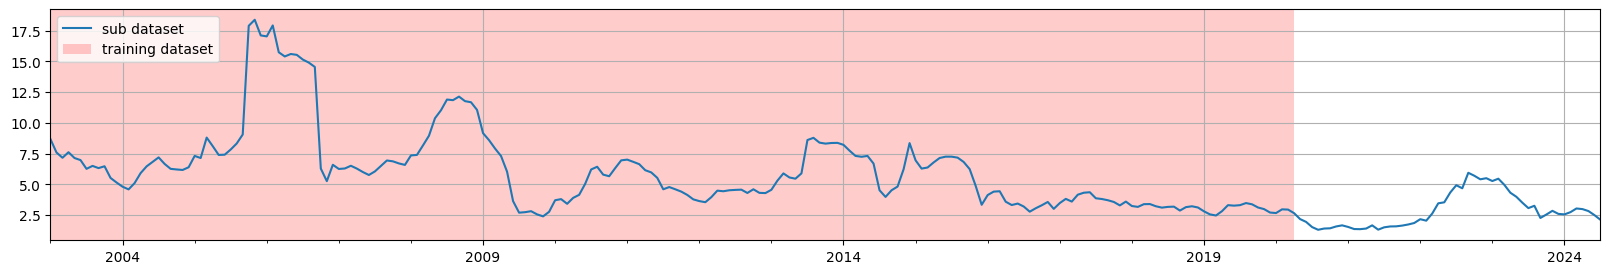

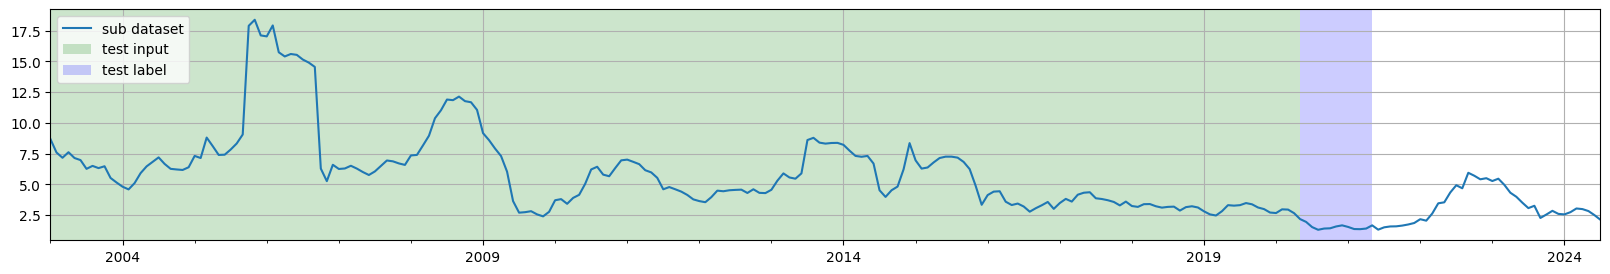

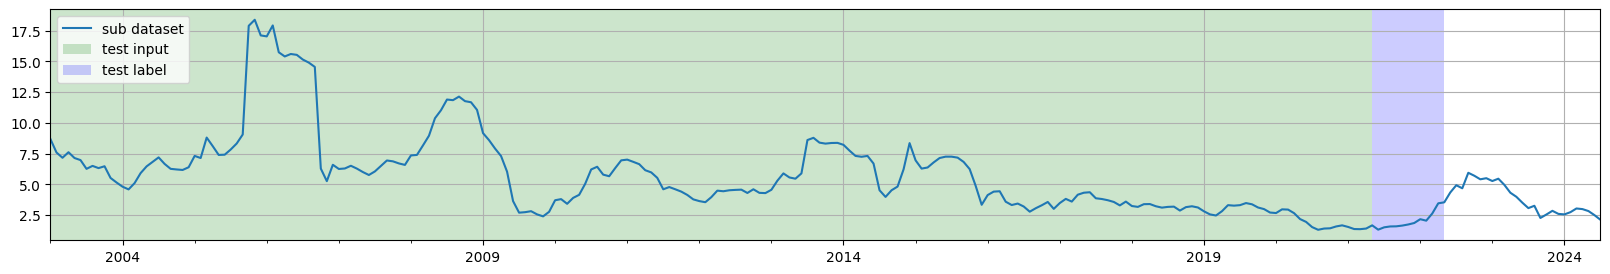

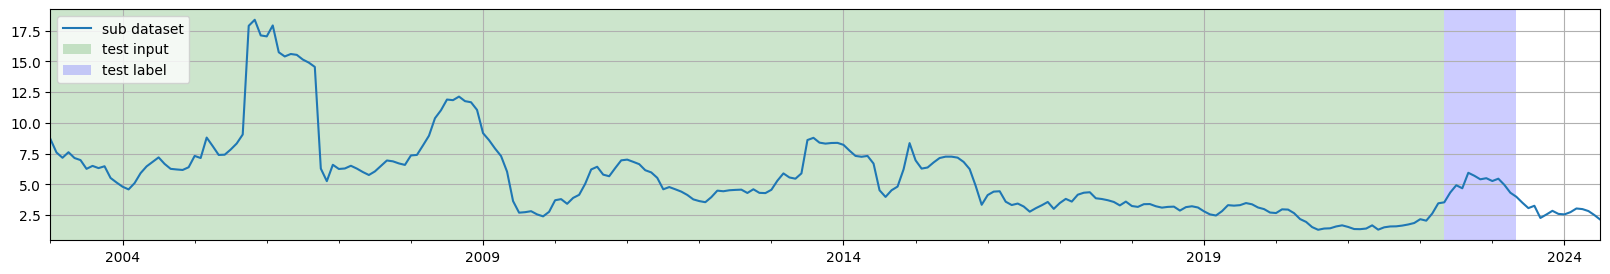

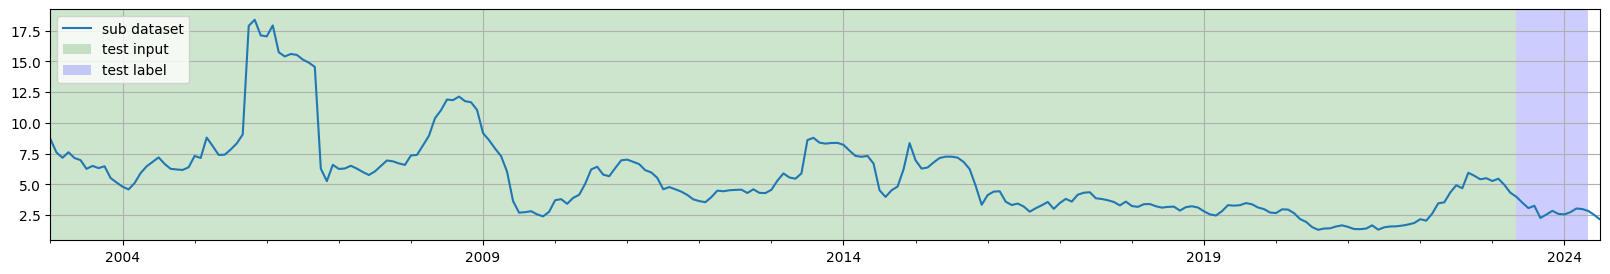

In [13]:
prediction_length = 12
training_dataset, _ = split(dataset, date=pd.Period("2020-03-31", freq="M"))
_, test_template = split(dataset, date=pd.Period("2020-04-30", freq="M"))
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=4,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

In [14]:
# def split_data(data, split_date):
#     """
#     Memisahkan data menjadi training dan test set berdasarkan split_date.
#     split_date harus dalam format yang cocok dengan indeks DataFrame.
#     """
#     train_data = data[data.index <= split_date]
#     test_data = data[data.index > split_date]
#     return train_data, test_data

# split_date_train = pd.Timestamp("2020-03-31")
# split_date_test = pd.Timestamp("2020-04-30")

# training_dataset, _ = split_data(dataset, split_date_train)
# _, test_dataset = split_data(dataset, split_date_test)

# # Menampilkan hasil
# print("Training Dataset:")
# print(training_dataset)
# print("\nTest Dataset:")
# print(test_dataset)

In [15]:
print(training_dataset)

TrainingDataset(dataset=PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=DateSplitter(date=Period('2020-03', 'M')))


In [16]:
train_entry = next(iter(training_dataset))
print(train_entry)

{'start': Period('2003-01', 'M'), 'target': array([ 8.68,  7.6 ,  7.17,  7.62,  7.15,  6.98,  6.27,  6.51,  6.33,
        6.48,  5.53,  5.16,  4.82,  4.6 ,  5.11,  5.92,  6.47,  6.83,
        7.2 ,  6.67,  6.27,  6.22,  6.18,  6.4 ,  7.32,  7.15,  8.81,
        8.12,  7.4 ,  7.42,  7.84,  8.33,  9.06, 17.89, 18.38, 17.11,
       17.03, 17.92, 15.74, 15.4 , 15.6 , 15.53, 15.15, 14.9 , 14.55,
        6.29,  5.27,  6.6 ,  6.26,  6.3 ,  6.52,  6.29,  6.01,  5.77,
        6.06,  6.51,  6.95,  6.88,  6.71,  6.59,  7.36,  7.4 ,  8.17,
        8.96, 10.38, 11.03, 11.9 , 11.85, 12.14, 11.77, 11.68, 11.06,
        9.17,  8.6 ,  7.92,  7.31,  6.04,  3.65,  2.71,  2.75,  2.83,
        2.57,  2.41,  2.78,  3.72,  3.81,  3.43,  3.91,  4.16,  5.05,
        6.22,  6.44,  5.8 ,  5.67,  6.33,  6.96,  7.02,  6.84,  6.65,
        6.16,  5.98,  5.54,  4.61,  4.79,  4.61,  4.42,  4.15,  3.79,
        3.65,  3.56,  3.97,  4.5 ,  4.45,  4.53,  4.56,  4.58,  4.31,
        4.61,  4.32,  4.3 ,  4.57,  5.31,  5.9

In [17]:
test_entry = next(iter(test_pairs))
print(test_entry)

({'start': Period('2003-01', 'M'), 'target': array([ 8.68,  7.6 ,  7.17,  7.62,  7.15,  6.98,  6.27,  6.51,  6.33,
        6.48,  5.53,  5.16,  4.82,  4.6 ,  5.11,  5.92,  6.47,  6.83,
        7.2 ,  6.67,  6.27,  6.22,  6.18,  6.4 ,  7.32,  7.15,  8.81,
        8.12,  7.4 ,  7.42,  7.84,  8.33,  9.06, 17.89, 18.38, 17.11,
       17.03, 17.92, 15.74, 15.4 , 15.6 , 15.53, 15.15, 14.9 , 14.55,
        6.29,  5.27,  6.6 ,  6.26,  6.3 ,  6.52,  6.29,  6.01,  5.77,
        6.06,  6.51,  6.95,  6.88,  6.71,  6.59,  7.36,  7.4 ,  8.17,
        8.96, 10.38, 11.03, 11.9 , 11.85, 12.14, 11.77, 11.68, 11.06,
        9.17,  8.6 ,  7.92,  7.31,  6.04,  3.65,  2.71,  2.75,  2.83,
        2.57,  2.41,  2.78,  3.72,  3.81,  3.43,  3.91,  4.16,  5.05,
        6.22,  6.44,  5.8 ,  5.67,  6.33,  6.96,  7.02,  6.84,  6.65,
        6.16,  5.98,  5.54,  4.61,  4.79,  4.61,  4.42,  4.15,  3.79,
        3.65,  3.56,  3.97,  4.5 ,  4.45,  4.53,  4.56,  4.58,  4.31,
        4.61,  4.32,  4.3 ,  4.57,  5.31,  5.

In [18]:
print(test_pairs)
print(test_template)

TestData(dataset=PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=DateSplitter(date=Period('2020-04', 'M')), prediction_length=12, windows=4, distance=None, max_history=None)
TestTemplate(dataset=PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>, splitter=DateSplitter(date=Period('2020-04', 'M')))


In [23]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [24]:
print("TEST INPUT:\n",next(iter(test_pairs.input)))
print("LABEL INPUT:\n",next(iter(test_pairs.label)))

TEST INPUT:
 {'start': Period('2003-01', 'M'), 'target': array([ 8.68,  7.6 ,  7.17,  7.62,  7.15,  6.98,  6.27,  6.51,  6.33,
        6.48,  5.53,  5.16,  4.82,  4.6 ,  5.11,  5.92,  6.47,  6.83,
        7.2 ,  6.67,  6.27,  6.22,  6.18,  6.4 ,  7.32,  7.15,  8.81,
        8.12,  7.4 ,  7.42,  7.84,  8.33,  9.06, 17.89, 18.38, 17.11,
       17.03, 17.92, 15.74, 15.4 , 15.6 , 15.53, 15.15, 14.9 , 14.55,
        6.29,  5.27,  6.6 ,  6.26,  6.3 ,  6.52,  6.29,  6.01,  5.77,
        6.06,  6.51,  6.95,  6.88,  6.71,  6.59,  7.36,  7.4 ,  8.17,
        8.96, 10.38, 11.03, 11.9 , 11.85, 12.14, 11.77, 11.68, 11.06,
        9.17,  8.6 ,  7.92,  7.31,  6.04,  3.65,  2.71,  2.75,  2.83,
        2.57,  2.41,  2.78,  3.72,  3.81,  3.43,  3.91,  4.16,  5.05,
        6.22,  6.44,  5.8 ,  5.67,  6.33,  6.96,  7.02,  6.84,  6.65,
        6.16,  5.98,  5.54,  4.61,  4.79,  4.61,  4.42,  4.15,  3.79,
        3.65,  3.56,  3.97,  4.5 ,  4.45,  4.53,  4.56,  4.58,  4.31,
        4.61,  4.32,  4.3 ,  4.57

In [25]:
backtest_dataset = test_pairs.input
prediction_length = 12
num_samples = 2
device = torch.device("cuda:0")

In [26]:
#Get predictions
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_193380/42396323.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device) # Uses GPU sinc

In [27]:
print(len(forecasts))
print(forecasts[2].samples.shape)
# print(next(iter(forecasts)))
print(forecasts[0])
print(forecasts[1])
print(forecasts[2])
print(forecasts[3])
print(tss)

4
(100, 12)
gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 2.7807457 ,  2.7058377 ,  2.8610117 , ...,  3.5227823 ,
         4.847483  ,  5.1219206 ],
       [ 2.4708307 ,  2.3291597 ,  1.7754683 , ...,  0.5357127 ,
         0.77209616,  0.4839344 ],
       [ 2.642753  ,  2.5232918 ,  2.4545426 , ...,  2.3837383 ,
         3.019958  ,  3.9825873 ],
       ...,
       [ 2.936109  ,  2.7611856 ,  2.4336097 , ...,  2.903009  ,
         2.0814779 ,  1.5270581 ],
       [ 2.7544198 ,  2.99824   ,  3.4607513 , ...,  4.0009823 ,
         4.3514    ,  4.528164  ],
       [ 2.7142575 ,  2.7161465 ,  2.4958186 , ..., -1.1681709 ,
        -0.9883003 , -0.15444326]], dtype=float32), start_date=Period('2019-05', 'M'))
gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 2.0763817 ,  1.9466786 ,  1.1208954 , ...,  1.2049294 ,
         1.2529054 ,  1.6210284 ],
       [ 2.0886943 ,  2.0048923 ,  2.501504  , ...,  3.0761287 ,
         3.262544

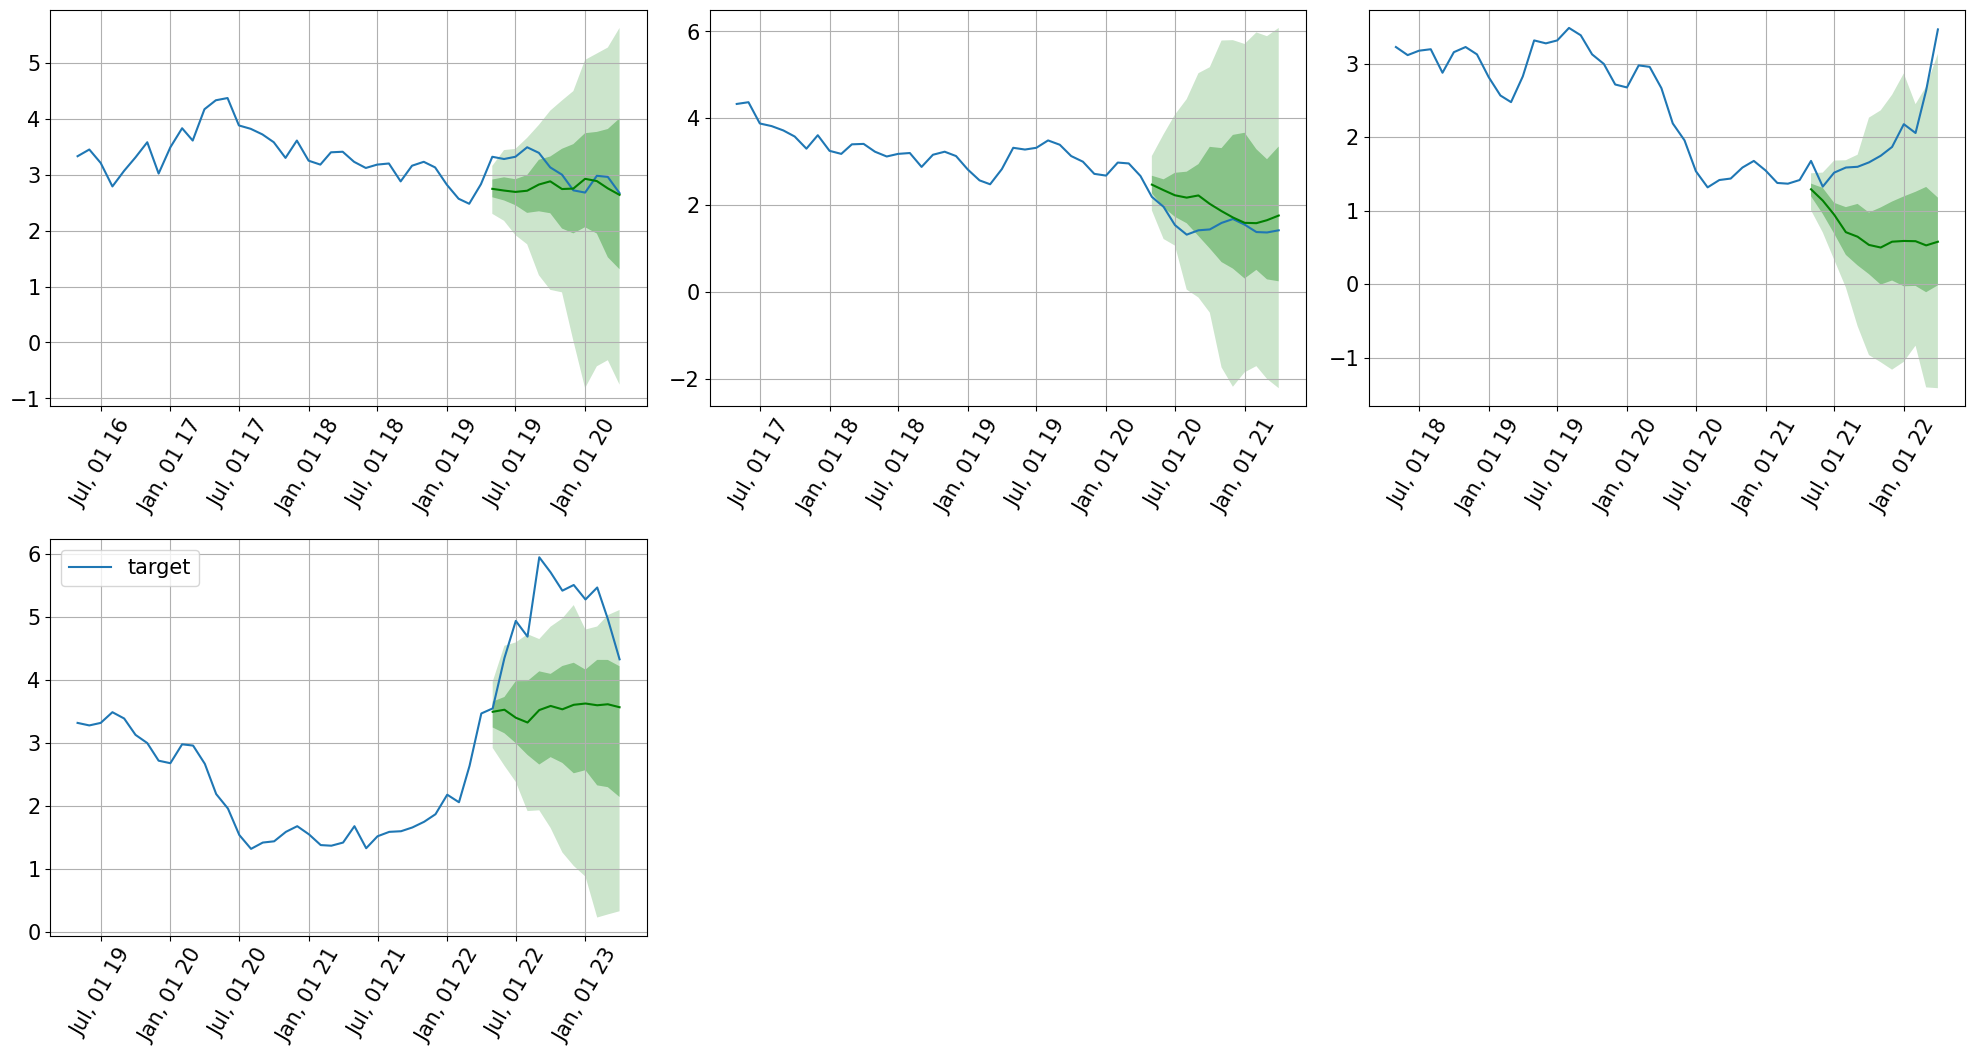

In [29]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [30]:
print(forecasts[0].samples.shape)
print(tss[0])
print(forecasts)

(100, 12)
            0
2003-01  8.68
2003-02  7.60
2003-03  7.17
2003-04  7.62
2003-05  7.15
...       ...
2019-12  2.72
2020-01  2.68
2020-02  2.98
2020-03  2.96
2020-04  2.67

[208 rows x 1 columns]
[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[ 2.7807457 ,  2.7058377 ,  2.8610117 , ...,  3.5227823 ,
         4.847483  ,  5.1219206 ],
       [ 2.4708307 ,  2.3291597 ,  1.7754683 , ...,  0.5357127 ,
         0.77209616,  0.4839344 ],
       [ 2.642753  ,  2.5232918 ,  2.4545426 , ...,  2.3837383 ,
         3.019958  ,  3.9825873 ],
       ...,
       [ 2.936109  ,  2.7611856 ,  2.4336097 , ...,  2.903009  ,
         2.0814779 ,  1.5270581 ],
       [ 2.7544198 ,  2.99824   ,  3.4607513 , ...,  4.0009823 ,
         4.3514    ,  4.528164  ],
       [ 2.7142575 ,  2.7161465 ,  2.4958186 , ..., -1.1681709 ,
        -0.9883003 , -0.15444326]], dtype=float32), start_date=Period('2019-05', 'M')), gluonts.model.forecast.SampleForecast(info=None, item_id=None

In [31]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 4it [00:00, 117.13it/s]
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [32]:
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])

CRPS: 0.26229522396131866
MSE: 1.4010420540968578
MAPE: 0.31125755359729135
